In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
import time
import matplotlib.pyplot as plt

/home/lucas/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:

class ALS:


    def __init__(self,R,W,TR,TW,Parameters):
        self.Rating_Matrix=R
        self.rows=Parameters['Row']
        self.cols=Parameters['Cols']
        self.K=Parameters['K']
        self.m_lambda=Parameters['Lambda']
        self.max_loops=Parameters['Max Loops']
        self.epsilon=Parameters['epsilon']
        self.Weight_Matrix=W
        self.Test_Rating_Matrix=TR
        self.Test_Weight_Matrix=TW


    def iteraton(self, matrix_fixed):
        tic=time.time()
        if matrix_fixed== 'P_Matrix':
            solve_vecs=np.linalg.solve(np.dot(self.P_Matrix.T,self.P_Matrix)+self.m_lambda*np.eye(self.K),
                                       np.dot(self.P_Matrix.T,self.Rating_Matrix)).T
        else:
            solve_vecs=np.linalg.solve(np.dot(self.Q_Matrix.T,self.Q_Matrix)+self.m_lambda*np.eye(self.K),
                                        np.dot(self.Q_Matrix.T,self.Rating_Matrix.T)).T
        print('Update {} Successfully. Time:{:0.5f}s'.format(matrix_fixed,time.time()-tic))
        return solve_vecs


    def RMSE(self,Rating_Matrix):
        Predict = self.P_Matrix.dot(self.Q_Matrix.T)
        SEL = (np.asarray((Rating_Matrix - Predict) )** 2).sum()
        return np.sqrt(SEL / (self.rows * self.cols))


    def draw(self):
        loops=self.max_loops
        plt.plot(np.arange(0, loops - 1, 1), self.train_rmse[0:loops - 1], label='Train_RMSE')
        plt.plot(np.arange(0, loops - 1, 1), self.test_rmse[0:loops - 1], label='Test_RMSE')
        plt.xlabel('loops')
        plt.ylabel('RMSE')
        plt.title('RMSE')
        plt.legend()
        plt.show()

        loops=self.max_loops
        plt.plot(np.arange(0, loops - 1, 1), self.test_Loss[0:loops - 1], label='Test_Loss')
        plt.plot(np.arange(0, loops - 1, 1), self.train_Loss[0:loops - 1], label='Train_Loss')
        plt.xlabel('loops')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.legend()
        plt.show()


    def loss(self,Rating_Matrix,Weight_Matrix):
        Predict=self.P_Matrix.dot(self.Q_Matrix.T)
        SEL = np.sum((Weight_Matrix * np.asarray(Rating_Matrix - Predict))**2)
        RP=0
        RQ=0
        for i in range(0,self.rows):
            RP+=self.m_lambda*self.P_Matrix[i,:].dot(self.P_Matrix[i,:].T)
        for i in range(0,self.cols):
            RQ+=self.m_lambda*self.Q_Matrix[i,:].dot(self.Q_Matrix[i,:].T)
        LOSS=SEL+RP+RQ
        return LOSS/(self.rows*self.cols)



    def train(self):
        tic=time.time()
        self.train_rmse=[]
        self.train_Loss=[]
        self.test_rmse=[]
        self.test_Loss=[]
        self.P_Matrix=np.random.normal(size=(self.rows,self.K))
        self.Q_Matrix=np.random.normal(size=(self.cols,self.K))
        count=0
        rmse=1
        while count<self.max_loops:
            if rmse<self.epsilon:
                print('ALS Completed in loops {}, Time:{:0.2f}s'.format(count, time.time() - tic))
                break
            else:
                print('Update User Matrix for the {} time'.format(count))
                self.P_Matrix=self.iteraton('Q_Matrix')
                print('Update Item Matrix for the {} time'.format(count))
                self.Q_Matrix=self.iteraton('P_Matrix')

                train_rmse=self.RMSE(self.Rating_Matrix)
                train_loss=self.loss(self.Rating_Matrix,self.Weight_Matrix)
                test_rmse=self.RMSE(self.Test_Rating_Matrix)
                test_loss=self.loss(self.Test_Rating_Matrix,self.Test_Weight_Matrix)

                self.train_rmse.append(train_rmse)
                self.train_Loss.append(train_loss)
                self.test_rmse.append(test_rmse)
                self.test_Loss.append(test_loss)

                print('Loops:{} Completed. Train: RMSE:{:0.2f},Loss:{:0.2f}; Test: RMSE:{:0.2f},Loss:{:0.2f}'
                      .format(count, train_rmse,train_loss,test_rmse,test_loss))

                count=count+1
            print('ALS Completed, Time:{:0.2f}s'.format(time.time() - tic))

In [3]:

def loadMovieLens(parametes,directory_path):
    tic=time.time()
    rows=parametes['Row']
    cols=parametes['Cols']
    mode=parametes['Mode']
    # Method:Hold-Out
    if mode==0:
        file_path=directory_path+'/u.data'
        Train_Rating_Matrix=np.zeros(shape=(rows,cols))
        Train_Weight_Matrix = np.zeros(shape=(rows, cols))
        Test_Rating_Matrix=np.zeros(shape=(rows,cols))
        Test_Weight_Matrix = np.zeros(shape=(rows, cols))
        origin_data=np.loadtxt(file_path)
        train,test=train_test_split(origin_data,test_size=0.2,random_state=1)
        for i in range(0,train.shape[0]):
            user_id=int(train[i][0])
            item_id=int(train[i][1])
            rating=train[i][2]
            Train_Rating_Matrix[user_id-1,item_id-1]=rating
            if rating!=0:
                Train_Weight_Matrix[user_id - 1, item_id - 1] = rating
        for i in range(0,test.shape[0]):
            user_id=int(test[i][0])
            item_id=int(test[i][1])
            rating=test[i][2]
            Test_Rating_Matrix[user_id-1,item_id-1]=rating
            if rating!=0:
                Test_Weight_Matrix[user_id - 1, item_id - 1] = rating
        print('Loading MovieLen Successfully. Time Used:{:0.2f}. Mode:0'.format(time.time()-tic))
        return Train_Rating_Matrix,Train_Weight_Matrix,Test_Rating_Matrix,Test_Weight_Matrix

    # Method Cross validation
    if mode==1:
        Train_Rating_Matrixs=[]
        Train_Weight_Matrixs=[]
        Test_Rating_Matrixs=[]
        Test_Weight_Matrixs=[]
        for i in range(1,6):
            Train_Rating_Matrix = np.zeros(shape=(rows, cols))
            Train_Weight_Matrix = np.zeros(shape=(rows, cols))
            Test_Rating_Matrix = np.zeros(shape=(rows, cols))
            Test_Weight_Matrix = np.zeros(shape=(rows, cols))
            train_path = directory_path + '/u{}.base'.format(i)
            test_path = directory_path + '/u{}.test'.format(i)
            train_data = np.loadtxt(train_path)
            test_data = np.loadtxt(test_path)
            for i in range(0, train_data.shape[0]):
                user_id = int(train_data[i][0])
                item_id = int(train_data[i][1])
                rating = train_data[i][2]
                Train_Rating_Matrix[user_id - 1, item_id - 1] = rating
                if rating != 0:
                    Train_Weight_Matrix[user_id - 1, item_id - 1] = rating
            for i in range(0, test_data.shape[0]):
                user_id = int(test_data[i][0])
                item_id = int(test_data[i][1])
                rating = test_data[i][2]
                Test_Rating_Matrix[user_id - 1, item_id - 1] = rating
                if rating != 0:
                    Test_Weight_Matrix[user_id - 1, item_id - 1] = rating
            Train_Rating_Matrixs.append(Train_Rating_Matrix)
            Train_Weight_Matrixs.append(Train_Weight_Matrix)
            Test_Rating_Matrixs.append(Test_Rating_Matrix)
            Test_Weight_Matrixs.append(Test_Weight_Matrix)
        print('Loading MovieLen Successfully. Time Used:{:0.2f}. Mode:1'.format(time.time()-tic))
        Data=[Train_Rating_Matrixs,Train_Weight_Matrixs,Test_Rating_Matrixs,Test_Rating_Matrixs]
        return Data


In [4]:
def draw(loops,dic,x_label,y_label,title):
    loops = loops
    for m_label,list in dic.items():
        plt.plot(np.arange(0, loops - 1, 1), list[0:loops - 1], label=m_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

In [7]:
# Parameters
if __name__ == '__main__':
    dic_path='/home/lucas/Codes/GitHub/ML_Assignment1/Machine_Learning_Labs/DataSet/ml-100k'
    # Use the full dataset:u.data
    Parameters_1={
        'Row':943,
        'Cols':1682,
        'Mode':0,
        'K':40,
        'Lambda':0.1,
        'Max Loops':100,
        'epsilon':0.00001
    }
    # Use the five divided dataset
    Parameters_2={
        'Row':943,
        'Cols':1682,
        'Mode':1,
        'K':40,
        'Lambda':0.1,
        'Max Loops':100,
        'epsilon':0.00001
    }

Loading MovieLen Successfully. Time Used:0.76. Mode:0
Update User Matrix for the 0 time
Update Q_Matrix Successfully. Time:0.00593s
Update Item Matrix for the 0 time
Update P_Matrix Successfully. Time:0.00178s
Loops:0 Completed. Train: RMSE:0.66,Loss:6.05; Test: RMSE:0.55,Loss:1.93
ALS Completed, Time:0.06s
Update User Matrix for the 1 time
Update Q_Matrix Successfully. Time:0.00137s
Update Item Matrix for the 1 time
Update P_Matrix Successfully. Time:0.00146s
Loops:1 Completed. Train: RMSE:0.60,Loss:4.55; Test: RMSE:0.61,Loss:1.77
ALS Completed, Time:0.10s
Update User Matrix for the 2 time
Update Q_Matrix Successfully. Time:0.00152s
Update Item Matrix for the 2 time
Update P_Matrix Successfully. Time:0.00164s
Loops:2 Completed. Train: RMSE:0.59,Loss:4.31; Test: RMSE:0.62,Loss:1.77
ALS Completed, Time:0.15s
Update User Matrix for the 3 time
Update Q_Matrix Successfully. Time:0.00137s
Update Item Matrix for the 3 time
Update P_Matrix Successfully. Time:0.00147s
Loops:3 Completed. Train:

Loops:36 Completed. Train: RMSE:0.58,Loss:3.99; Test: RMSE:0.65,Loss:1.78
ALS Completed, Time:1.88s
Update User Matrix for the 37 time
Update Q_Matrix Successfully. Time:0.00426s
Update Item Matrix for the 37 time
Update P_Matrix Successfully. Time:0.00152s
Loops:37 Completed. Train: RMSE:0.58,Loss:3.99; Test: RMSE:0.65,Loss:1.78
ALS Completed, Time:1.92s
Update User Matrix for the 38 time
Update Q_Matrix Successfully. Time:0.00247s
Update Item Matrix for the 38 time
Update P_Matrix Successfully. Time:0.00177s
Loops:38 Completed. Train: RMSE:0.58,Loss:3.99; Test: RMSE:0.65,Loss:1.78
ALS Completed, Time:1.97s
Update User Matrix for the 39 time
Update Q_Matrix Successfully. Time:0.00140s
Update Item Matrix for the 39 time
Update P_Matrix Successfully. Time:0.00148s
Loops:39 Completed. Train: RMSE:0.58,Loss:3.99; Test: RMSE:0.65,Loss:1.78
ALS Completed, Time:2.02s
Update User Matrix for the 40 time
Update Q_Matrix Successfully. Time:0.00144s
Update Item Matrix for the 40 time
Update P_Mat

Loops:71 Completed. Train: RMSE:0.58,Loss:3.97; Test: RMSE:0.65,Loss:1.78
ALS Completed, Time:3.75s
Update User Matrix for the 72 time
Update Q_Matrix Successfully. Time:0.00171s
Update Item Matrix for the 72 time
Update P_Matrix Successfully. Time:0.00158s
Loops:72 Completed. Train: RMSE:0.58,Loss:3.97; Test: RMSE:0.65,Loss:1.78
ALS Completed, Time:3.79s
Update User Matrix for the 73 time
Update Q_Matrix Successfully. Time:0.00216s
Update Item Matrix for the 73 time
Update P_Matrix Successfully. Time:0.00184s
Loops:73 Completed. Train: RMSE:0.58,Loss:3.97; Test: RMSE:0.65,Loss:1.78
ALS Completed, Time:3.84s
Update User Matrix for the 74 time
Update Q_Matrix Successfully. Time:0.00157s
Update Item Matrix for the 74 time
Update P_Matrix Successfully. Time:0.00169s
Loops:74 Completed. Train: RMSE:0.58,Loss:3.97; Test: RMSE:0.65,Loss:1.78
ALS Completed, Time:3.88s
Update User Matrix for the 75 time
Update Q_Matrix Successfully. Time:0.00196s
Update Item Matrix for the 75 time
Update P_Mat

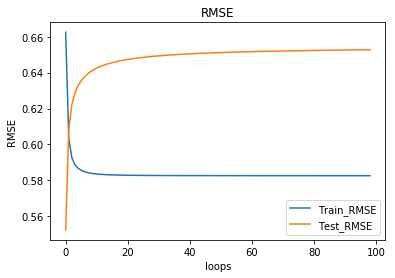

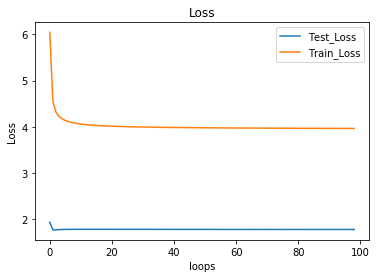

In [9]:
    # Use the full dataset:u.data and train one model
    Train_Rating_Matrix, Train_Weight_Matrix, Test_Rating_Matrix, Test_Weight_Matrix = loadMovieLens(Parameters_1,
                                                                                                         dic_path)
    ALS_0 = ALS(Train_Rating_Matrix, Train_Weight_Matrix, Test_Rating_Matrix, Test_Weight_Matrix, Parameters_1)
    ALS_0.train()
     ALS_0.draw()

Loading MovieLen Successfully. Time Used:3.70. Mode:1
Begin Trainning Model0
Update User Matrix for the 0 time
Update Q_Matrix Successfully. Time:0.01132s
Update Item Matrix for the 0 time
Update P_Matrix Successfully. Time:0.00168s
Loops:0 Completed. Train: RMSE:0.65,Loss:5.96; Test: RMSE:0.58,Loss:2.27
ALS Completed, Time:0.07s
Update User Matrix for the 1 time
Update Q_Matrix Successfully. Time:0.00526s
Update Item Matrix for the 1 time
Update P_Matrix Successfully. Time:0.00837s
Loops:1 Completed. Train: RMSE:0.59,Loss:4.40; Test: RMSE:0.64,Loss:2.10
ALS Completed, Time:0.13s
Update User Matrix for the 2 time
Update Q_Matrix Successfully. Time:0.00145s
Update Item Matrix for the 2 time
Update P_Matrix Successfully. Time:0.00146s
Loops:2 Completed. Train: RMSE:0.58,Loss:4.18; Test: RMSE:0.65,Loss:2.10
ALS Completed, Time:0.17s
Update User Matrix for the 3 time
Update Q_Matrix Successfully. Time:0.00162s
Update Item Matrix for the 3 time
Update P_Matrix Successfully. Time:0.00147s
Lo

Loops:33 Completed. Train: RMSE:0.57,Loss:3.85; Test: RMSE:0.68,Loss:2.09
ALS Completed, Time:1.83s
Update User Matrix for the 34 time
Update Q_Matrix Successfully. Time:0.00395s
Update Item Matrix for the 34 time
Update P_Matrix Successfully. Time:0.00148s
Loops:34 Completed. Train: RMSE:0.57,Loss:3.85; Test: RMSE:0.68,Loss:2.09
ALS Completed, Time:1.87s
Update User Matrix for the 35 time
Update Q_Matrix Successfully. Time:0.00159s
Update Item Matrix for the 35 time
Update P_Matrix Successfully. Time:0.00147s
Loops:35 Completed. Train: RMSE:0.57,Loss:3.85; Test: RMSE:0.68,Loss:2.09
ALS Completed, Time:1.90s
Update User Matrix for the 36 time
Update Q_Matrix Successfully. Time:0.00159s
Update Item Matrix for the 36 time
Update P_Matrix Successfully. Time:0.00134s
Loops:36 Completed. Train: RMSE:0.57,Loss:3.85; Test: RMSE:0.68,Loss:2.09
ALS Completed, Time:1.94s
Update User Matrix for the 37 time
Update Q_Matrix Successfully. Time:0.00158s
Update Item Matrix for the 37 time
Update P_Mat

Loops:67 Completed. Train: RMSE:0.57,Loss:3.83; Test: RMSE:0.68,Loss:2.08
ALS Completed, Time:3.20s
Update User Matrix for the 68 time
Update Q_Matrix Successfully. Time:0.00359s
Update Item Matrix for the 68 time
Update P_Matrix Successfully. Time:0.00149s
Loops:68 Completed. Train: RMSE:0.57,Loss:3.83; Test: RMSE:0.68,Loss:2.08
ALS Completed, Time:3.24s
Update User Matrix for the 69 time
Update Q_Matrix Successfully. Time:0.00158s
Update Item Matrix for the 69 time
Update P_Matrix Successfully. Time:0.00180s
Loops:69 Completed. Train: RMSE:0.57,Loss:3.83; Test: RMSE:0.68,Loss:2.08
ALS Completed, Time:3.28s
Update User Matrix for the 70 time
Update Q_Matrix Successfully. Time:0.00153s
Update Item Matrix for the 70 time
Update P_Matrix Successfully. Time:0.00144s
Loops:70 Completed. Train: RMSE:0.57,Loss:3.83; Test: RMSE:0.68,Loss:2.08
ALS Completed, Time:3.32s
Update User Matrix for the 71 time
Update Q_Matrix Successfully. Time:0.00159s
Update Item Matrix for the 71 time
Update P_Mat

Loops:1 Completed. Train: RMSE:0.60,Loss:4.52; Test: RMSE:0.62,Loss:1.94
ALS Completed, Time:0.09s
Update User Matrix for the 2 time
Update Q_Matrix Successfully. Time:0.00137s
Update Item Matrix for the 2 time
Update P_Matrix Successfully. Time:0.00132s
Loops:2 Completed. Train: RMSE:0.59,Loss:4.28; Test: RMSE:0.63,Loss:1.94
ALS Completed, Time:0.13s
Update User Matrix for the 3 time
Update Q_Matrix Successfully. Time:0.00150s
Update Item Matrix for the 3 time
Update P_Matrix Successfully. Time:0.00134s
Loops:3 Completed. Train: RMSE:0.58,Loss:4.18; Test: RMSE:0.64,Loss:1.95
ALS Completed, Time:0.16s
Update User Matrix for the 4 time
Update Q_Matrix Successfully. Time:0.00142s
Update Item Matrix for the 4 time
Update P_Matrix Successfully. Time:0.00131s
Loops:4 Completed. Train: RMSE:0.58,Loss:4.12; Test: RMSE:0.64,Loss:1.95
ALS Completed, Time:0.20s
Update User Matrix for the 5 time
Update Q_Matrix Successfully. Time:0.00149s
Update Item Matrix for the 5 time
Update P_Matrix Successf

Loops:35 Completed. Train: RMSE:0.58,Loss:3.92; Test: RMSE:0.66,Loss:1.94
ALS Completed, Time:1.64s
Update User Matrix for the 36 time
Update Q_Matrix Successfully. Time:0.00350s
Update Item Matrix for the 36 time
Update P_Matrix Successfully. Time:0.00803s
Loops:36 Completed. Train: RMSE:0.58,Loss:3.92; Test: RMSE:0.66,Loss:1.94
ALS Completed, Time:1.70s
Update User Matrix for the 37 time
Update Q_Matrix Successfully. Time:0.00144s
Update Item Matrix for the 37 time
Update P_Matrix Successfully. Time:0.00136s
Loops:37 Completed. Train: RMSE:0.58,Loss:3.92; Test: RMSE:0.66,Loss:1.94
ALS Completed, Time:1.74s
Update User Matrix for the 38 time
Update Q_Matrix Successfully. Time:0.00136s
Update Item Matrix for the 38 time
Update P_Matrix Successfully. Time:0.00137s
Loops:38 Completed. Train: RMSE:0.58,Loss:3.92; Test: RMSE:0.66,Loss:1.94
ALS Completed, Time:1.78s
Update User Matrix for the 39 time
Update Q_Matrix Successfully. Time:0.00190s
Update Item Matrix for the 39 time
Update P_Mat

Loops:68 Completed. Train: RMSE:0.58,Loss:3.90; Test: RMSE:0.67,Loss:1.94
ALS Completed, Time:3.20s
Update User Matrix for the 69 time
Update Q_Matrix Successfully. Time:0.01244s
Update Item Matrix for the 69 time
Update P_Matrix Successfully. Time:0.00154s
Loops:69 Completed. Train: RMSE:0.58,Loss:3.90; Test: RMSE:0.67,Loss:1.94
ALS Completed, Time:3.25s
Update User Matrix for the 70 time
Update Q_Matrix Successfully. Time:0.00136s
Update Item Matrix for the 70 time
Update P_Matrix Successfully. Time:0.00130s
Loops:70 Completed. Train: RMSE:0.58,Loss:3.90; Test: RMSE:0.67,Loss:1.94
ALS Completed, Time:3.29s
Update User Matrix for the 71 time
Update Q_Matrix Successfully. Time:0.00138s
Update Item Matrix for the 71 time
Update P_Matrix Successfully. Time:0.00134s
Loops:71 Completed. Train: RMSE:0.58,Loss:3.90; Test: RMSE:0.67,Loss:1.94
ALS Completed, Time:3.33s
Update User Matrix for the 72 time
Update Q_Matrix Successfully. Time:0.00136s
Update Item Matrix for the 72 time
Update P_Mat

Loops:1 Completed. Train: RMSE:0.60,Loss:4.52; Test: RMSE:0.62,Loss:1.86
ALS Completed, Time:0.11s
Update User Matrix for the 2 time
Update Q_Matrix Successfully. Time:0.00133s
Update Item Matrix for the 2 time
Update P_Matrix Successfully. Time:0.00130s
Loops:2 Completed. Train: RMSE:0.59,Loss:4.28; Test: RMSE:0.63,Loss:1.85
ALS Completed, Time:0.16s
Update User Matrix for the 3 time
Update Q_Matrix Successfully. Time:0.00765s
Update Item Matrix for the 3 time
Update P_Matrix Successfully. Time:0.00140s
Loops:3 Completed. Train: RMSE:0.58,Loss:4.18; Test: RMSE:0.64,Loss:1.85
ALS Completed, Time:0.20s
Update User Matrix for the 4 time
Update Q_Matrix Successfully. Time:0.00142s
Update Item Matrix for the 4 time
Update P_Matrix Successfully. Time:0.00131s
Loops:4 Completed. Train: RMSE:0.58,Loss:4.13; Test: RMSE:0.64,Loss:1.85
ALS Completed, Time:0.24s
Update User Matrix for the 5 time
Update Q_Matrix Successfully. Time:0.00144s
Update Item Matrix for the 5 time
Update P_Matrix Successf

Loops:33 Completed. Train: RMSE:0.58,Loss:3.95; Test: RMSE:0.66,Loss:1.84
ALS Completed, Time:1.45s
Update User Matrix for the 34 time
Update Q_Matrix Successfully. Time:0.00143s
Update Item Matrix for the 34 time
Update P_Matrix Successfully. Time:0.00130s
Loops:34 Completed. Train: RMSE:0.58,Loss:3.95; Test: RMSE:0.66,Loss:1.84
ALS Completed, Time:1.49s
Update User Matrix for the 35 time
Update Q_Matrix Successfully. Time:0.00143s
Update Item Matrix for the 35 time
Update P_Matrix Successfully. Time:0.00134s
Loops:35 Completed. Train: RMSE:0.58,Loss:3.95; Test: RMSE:0.66,Loss:1.84
ALS Completed, Time:1.52s
Update User Matrix for the 36 time
Update Q_Matrix Successfully. Time:0.00144s
Update Item Matrix for the 36 time
Update P_Matrix Successfully. Time:0.00128s
Loops:36 Completed. Train: RMSE:0.58,Loss:3.94; Test: RMSE:0.66,Loss:1.84
ALS Completed, Time:1.57s
Update User Matrix for the 37 time
Update Q_Matrix Successfully. Time:0.00138s
Update Item Matrix for the 37 time
Update P_Mat

Loops:68 Completed. Train: RMSE:0.58,Loss:3.92; Test: RMSE:0.66,Loss:1.84
ALS Completed, Time:2.88s
Update User Matrix for the 69 time
Update Q_Matrix Successfully. Time:0.00140s
Update Item Matrix for the 69 time
Update P_Matrix Successfully. Time:0.00135s
Loops:69 Completed. Train: RMSE:0.58,Loss:3.92; Test: RMSE:0.66,Loss:1.84
ALS Completed, Time:2.92s
Update User Matrix for the 70 time
Update Q_Matrix Successfully. Time:0.00137s
Update Item Matrix for the 70 time
Update P_Matrix Successfully. Time:0.00181s
Loops:70 Completed. Train: RMSE:0.58,Loss:3.92; Test: RMSE:0.66,Loss:1.84
ALS Completed, Time:2.96s
Update User Matrix for the 71 time
Update Q_Matrix Successfully. Time:0.00398s
Update Item Matrix for the 71 time
Update P_Matrix Successfully. Time:0.00154s
Loops:71 Completed. Train: RMSE:0.58,Loss:3.92; Test: RMSE:0.66,Loss:1.84
ALS Completed, Time:3.00s
Update User Matrix for the 72 time
Update Q_Matrix Successfully. Time:0.00138s
Update Item Matrix for the 72 time
Update P_Mat

Loops:0 Completed. Train: RMSE:0.66,Loss:6.09; Test: RMSE:0.56,Loss:2.07
ALS Completed, Time:0.06s
Update User Matrix for the 1 time
Update Q_Matrix Successfully. Time:0.00466s
Update Item Matrix for the 1 time
Update P_Matrix Successfully. Time:0.00148s
Loops:1 Completed. Train: RMSE:0.60,Loss:4.49; Test: RMSE:0.62,Loss:1.88
ALS Completed, Time:0.11s
Update User Matrix for the 2 time
Update Q_Matrix Successfully. Time:0.00147s
Update Item Matrix for the 2 time
Update P_Matrix Successfully. Time:0.00139s
Loops:2 Completed. Train: RMSE:0.59,Loss:4.27; Test: RMSE:0.63,Loss:1.87
ALS Completed, Time:0.15s
Update User Matrix for the 3 time
Update Q_Matrix Successfully. Time:0.00147s
Update Item Matrix for the 3 time
Update P_Matrix Successfully. Time:0.00136s
Loops:3 Completed. Train: RMSE:0.58,Loss:4.18; Test: RMSE:0.64,Loss:1.87
ALS Completed, Time:0.18s
Update User Matrix for the 4 time
Update Q_Matrix Successfully. Time:0.00141s
Update Item Matrix for the 4 time
Update P_Matrix Successf

Loops:36 Completed. Train: RMSE:0.58,Loss:3.93; Test: RMSE:0.66,Loss:1.85
ALS Completed, Time:1.61s
Update User Matrix for the 37 time
Update Q_Matrix Successfully. Time:0.00135s
Update Item Matrix for the 37 time
Update P_Matrix Successfully. Time:0.00145s
Loops:37 Completed. Train: RMSE:0.58,Loss:3.93; Test: RMSE:0.66,Loss:1.85
ALS Completed, Time:1.66s
Update User Matrix for the 38 time
Update Q_Matrix Successfully. Time:0.00139s
Update Item Matrix for the 38 time
Update P_Matrix Successfully. Time:0.00137s
Loops:38 Completed. Train: RMSE:0.58,Loss:3.93; Test: RMSE:0.66,Loss:1.85
ALS Completed, Time:1.70s
Update User Matrix for the 39 time
Update Q_Matrix Successfully. Time:0.00149s
Update Item Matrix for the 39 time
Update P_Matrix Successfully. Time:0.00137s
Loops:39 Completed. Train: RMSE:0.58,Loss:3.93; Test: RMSE:0.66,Loss:1.85
ALS Completed, Time:1.74s
Update User Matrix for the 40 time
Update Q_Matrix Successfully. Time:0.00209s
Update Item Matrix for the 40 time
Update P_Mat

Loops:72 Completed. Train: RMSE:0.58,Loss:3.91; Test: RMSE:0.66,Loss:1.85
ALS Completed, Time:3.13s
Update User Matrix for the 73 time
Update Q_Matrix Successfully. Time:0.01755s
Update Item Matrix for the 73 time
Update P_Matrix Successfully. Time:0.00191s
Loops:73 Completed. Train: RMSE:0.58,Loss:3.91; Test: RMSE:0.66,Loss:1.85
ALS Completed, Time:3.20s
Update User Matrix for the 74 time
Update Q_Matrix Successfully. Time:0.00143s
Update Item Matrix for the 74 time
Update P_Matrix Successfully. Time:0.00169s
Loops:74 Completed. Train: RMSE:0.58,Loss:3.91; Test: RMSE:0.66,Loss:1.85
ALS Completed, Time:3.26s
Update User Matrix for the 75 time
Update Q_Matrix Successfully. Time:0.00665s
Update Item Matrix for the 75 time
Update P_Matrix Successfully. Time:0.00139s
Loops:75 Completed. Train: RMSE:0.58,Loss:3.91; Test: RMSE:0.66,Loss:1.85
ALS Completed, Time:3.32s
Update User Matrix for the 76 time
Update Q_Matrix Successfully. Time:0.00142s
Update Item Matrix for the 76 time
Update P_Mat

Loops:7 Completed. Train: RMSE:0.57,Loss:3.97; Test: RMSE:0.66,Loss:1.95
ALS Completed, Time:0.36s
Update User Matrix for the 8 time
Update Q_Matrix Successfully. Time:0.00140s
Update Item Matrix for the 8 time
Update P_Matrix Successfully. Time:0.00183s
Loops:8 Completed. Train: RMSE:0.57,Loss:3.96; Test: RMSE:0.66,Loss:1.95
ALS Completed, Time:0.39s
Update User Matrix for the 9 time
Update Q_Matrix Successfully. Time:0.00145s
Update Item Matrix for the 9 time
Update P_Matrix Successfully. Time:0.00138s
Loops:9 Completed. Train: RMSE:0.57,Loss:3.95; Test: RMSE:0.66,Loss:1.95
ALS Completed, Time:0.43s
Update User Matrix for the 10 time
Update Q_Matrix Successfully. Time:0.00152s
Update Item Matrix for the 10 time
Update P_Matrix Successfully. Time:0.00139s
Loops:10 Completed. Train: RMSE:0.57,Loss:3.94; Test: RMSE:0.66,Loss:1.95
ALS Completed, Time:0.47s
Update User Matrix for the 11 time
Update Q_Matrix Successfully. Time:0.00143s
Update Item Matrix for the 11 time
Update P_Matrix Suc

Loops:43 Completed. Train: RMSE:0.57,Loss:3.86; Test: RMSE:0.67,Loss:1.93
ALS Completed, Time:1.77s
Update User Matrix for the 44 time
Update Q_Matrix Successfully. Time:0.00195s
Update Item Matrix for the 44 time
Update P_Matrix Successfully. Time:0.00146s
Loops:44 Completed. Train: RMSE:0.57,Loss:3.86; Test: RMSE:0.67,Loss:1.93
ALS Completed, Time:1.81s
Update User Matrix for the 45 time
Update Q_Matrix Successfully. Time:0.00149s
Update Item Matrix for the 45 time
Update P_Matrix Successfully. Time:0.00144s
Loops:45 Completed. Train: RMSE:0.57,Loss:3.86; Test: RMSE:0.67,Loss:1.93
ALS Completed, Time:1.84s
Update User Matrix for the 46 time
Update Q_Matrix Successfully. Time:0.00146s
Update Item Matrix for the 46 time
Update P_Matrix Successfully. Time:0.00137s
Loops:46 Completed. Train: RMSE:0.57,Loss:3.86; Test: RMSE:0.67,Loss:1.93
ALS Completed, Time:1.88s
Update User Matrix for the 47 time
Update Q_Matrix Successfully. Time:0.00146s
Update Item Matrix for the 47 time
Update P_Mat

Loops:80 Completed. Train: RMSE:0.57,Loss:3.85; Test: RMSE:0.67,Loss:1.93
ALS Completed, Time:3.34s
Update User Matrix for the 81 time
Update Q_Matrix Successfully. Time:0.00143s
Update Item Matrix for the 81 time
Update P_Matrix Successfully. Time:0.00135s
Loops:81 Completed. Train: RMSE:0.57,Loss:3.84; Test: RMSE:0.67,Loss:1.93
ALS Completed, Time:3.39s
Update User Matrix for the 82 time
Update Q_Matrix Successfully. Time:0.00144s
Update Item Matrix for the 82 time
Update P_Matrix Successfully. Time:0.00140s
Loops:82 Completed. Train: RMSE:0.57,Loss:3.84; Test: RMSE:0.67,Loss:1.93
ALS Completed, Time:3.42s
Update User Matrix for the 83 time
Update Q_Matrix Successfully. Time:0.00145s
Update Item Matrix for the 83 time
Update P_Matrix Successfully. Time:0.00139s
Loops:83 Completed. Train: RMSE:0.57,Loss:3.84; Test: RMSE:0.67,Loss:1.93
ALS Completed, Time:3.46s
Update User Matrix for the 84 time
Update Q_Matrix Successfully. Time:0.00147s
Update Item Matrix for the 84 time
Update P_Mat

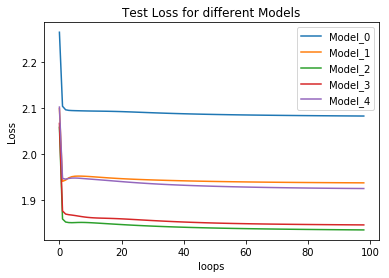

In [11]:
        # Use the five divided dataset and train 5 different models, then draw their curves
        Data=loadMovieLens(Parameters_2,dic_path)
        Models=[]
        for i in range(0,5):
            tic=time.time()
            print('Begin Trainning Model{}'.format(i))
            model=ALS(Data[0][i],Data[1][i],Data[2][i],Data[3][i],Parameters_2)
            model.train()
            print('Model_{} Completed. Time {:0.2f}s'.format(i,time.time()-tic))
            Models.append(model)
        dic={'Model_0':Models[0].test_Loss,
             'Model_1': Models[1].test_Loss,
             'Model_2': Models[2].test_Loss,
             'Model_3': Models[3].test_Loss,
             'Model_4': Models[4].test_Loss,}
        draw(Parameters_2['Max Loops'],dic,'loops','Loss','Test Loss for different Models')